In [202]:
import numpy as np
import pandas as pd
import requests
from lxml import html
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import time
import pickle
import seaborn as sns
import statsmodels.api as sm

In [78]:
def get_web_content(addr, ret = 'html'):
    try:
        pageContent = requests.get(addr) 
    except:
        print('Webpage inaccessible, please correct webpage address')
        
    if ret == 'html':
        return html.fromstring(pageContent.content)
    elif ret == 'soup':
        return BeautifulSoup(pageContent.text, 'html.parser')
    elif ret == 'htmlsoup':
        return (html.fromstring(pageContent.content),BeautifulSoup(pageContent.text, 'html.parser'))
    else:
        print('Error: ret tag is invalid in get_web_content')
        return None

        
def get_table_row(tree, xpath, counter):
    try:
        return tree.xpath(xpath.format(counter))
    except:
        print('Cannot extract table rows, check Xpath path and/or row index where content starts (int(counter))')
    

def get_cleaned_row(html_text):
    
    cleaned_html_text=[]
    
    for i in range(len(html_text)-1):
        if html_text[i] != '\n' and html_text[i+1] != '\n':
            j = 1
            while html_text[i+j] != '\n':
                html_text[i] = html_text[i] + html_text[i+j]
                html_text[i+j] = '\n'
                j += 1

    for elem in html_text:
        if elem != '\n':
            cleaned_html_text.append(elem.replace('\n',''))
    
    return cleaned_html_text[0:7]
    

def get_wiki_table(addr, xpath, counter, assembled_list = None):

    tree = get_web_content(addr,'html')
    html_text = get_table_row(tree, xpath, counter)
    
    if not assembled_list:
        assembled_list = []
    
    while html_text:
        assembled_list.append(get_cleaned_row(html_text))
        counter += 1
        html_text = get_table_row(tree, xpath, counter)
        
    return assembled_list  

In [157]:
xpath_0_m = '/html/body/div[3]/div[3]/div[4]/div/table[2]//tr[{}]//text()'
html_add_0_m = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games'

full_list = get_wiki_table(html_add_0_m, xpath_0_m, 3)

xpath_m_z = '/html/body/div[3]/div[3]/div[4]/div/table/tbody/tr[{}]//text()'
html_add_m_z = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games_(M-Z)'

full_list = get_wiki_table(html_add_m_z, xpath_m_z, 3, full_list)

try:
    ps4_game_list = pd.DataFrame(full_list,columns=['Titles','Genres','Developers','Publishers','ReleaseDate_JP','ReleaseDate_EU','ReleaseDate_NA'] )
except:
    print('Error: issues with converting scraped wiki table data into DataFrame.')
    
release_list = ['ReleaseDate_JP','ReleaseDate_EU','ReleaseDate_NA']

for col in release_list:
    try:
        ps4_game_list[col]=pd.to_datetime(ps4_game_list[col],infer_datetime_format=True,errors='coerce')
    except:
        print('Could not convert scraped release date columns into datetime format.')

punc_dict={ord('\''):None, ord(':'):None, ord('#'):None, ord('/'):' ', 
           ord('&'):None, ord(';'):' ', ord('!'):None, ord(','):None, ord('?'):None, ord('.'):None}        
    
ps4_game_list['TitlesHTML'] = ps4_game_list['Titles'].str.replace('\.0',' 0').str.replace('\.1',' 1').str.replace('\.5',' 5').str.replace(' -',' ').str.replace('//',' ').str.translate(punc_dict).str.replace('  ',' ').str.strip().str.lower().str.replace(' ','+')        

ps4_game_list.to_csv('ps4_game_list.csv')

ps4_game_list.head(15)

,Titles,Genres,Developers,Publishers,ReleaseDate_JP,ReleaseDate_EU,ReleaseDate_NA,TitlesHTML
0,#killallzombies,Shooter,Beatshapers,Beatshapers,NaT,2014-11-12,2014-10-28,killallzombies
1,10 Second Ninja X,Platform,Four Circle Interactive,Curve Digital,NaT,2016-07-19,2016-07-19,10+second+ninja+x
2,100ft Robot Golf,Sports,No Goblin,No Goblin,NaT,2016-10-10,2016-10-10,100ft+robot+golf
3,101 Ways to Die,"Platform, puzzle",Four Door Lemon,Vision Games,NaT,2016-03-22,2016-03-22,101+ways+to+die
4,11-11: Memories Retold,Adventure,AardmanDigixArt,Bandai Namco Entertainment,2018-11-09,2018-11-09,2018-11-09,11-11+memories+retold
5,13 Sentinels: Aegis Rim,Adventure,Vanillaware,Atlus,2019-11-28,NaT,NaT,13+sentinels+aegis+rim
6,140,Platform,Double Fine Productions,Abstraction Games,NaT,2016-09-01,2016-09-01,140
7,198X,Arcade,Hi-Bit Studios,Reset Media,NaT,2019-06-20,2019-06-16,198x
8,1001 Spikes,Platform,8bits Fanatics,Nicalis,2015-11-27,2015-10-07,2014-06-03,1001+spikes
9,2064: Read Only Memories,Adventure,MidBoss,MidBoss,2017-01-17,2017-01-17,2017-01-17,2064+read+only+memories


In [250]:
def find_pricing_script(script_tag):
    find = False
    counter = -1
    while not find:
        counter += 1
        try:
            script_text = script_tag[counter].text
        except:
            print('Could not find script with the price history, check web address.')
            
        if 'Price, USD' in script_text:
            find = True
            
    return script_text

def find_reg(reg_str,content):
    reg_find = re.findall(reg_str,content)
    assert reg_find is not None, "Could not extract any content, check regex string"
    return reg_find

    
def get_reg_output(soup, reg_string):
    script_text = find_pricing_script(soup.find_all('script'))
    script_text_cut = script_text[0:script_text.find('PS+')]
    return find_reg(reg_string, script_text_cut)  

def convert_date_to_cumdays(series):
    newseries = series.copy()
    newseries[0] = 0
    newseries.iloc[1:] = series.diff().iloc[1:].cumsum().dt.days
    return newseries.astype(float)

def convert_normlogprice(series):
    return np.log(series.div(series[0]))
    
def convert_price_todataframe(reg_output):
    try:
        price_history = pd.DataFrame(reg_output, columns = ['Date','Price'])
    except:
        print('Could not convert scraped price history to dataframe. Check regex function.')
    try:
        price_history['Date'] = pd.to_datetime(price_history['Date'],infer_datetime_format=True,errors='coerce')
    except:
        print('Could not convert scraped price history dates into datetime format')
    try:
        price_history['Price'] = pd.to_numeric(price_history['Price'],errors='coerce')
    except:
        print('Could not convert scraped prices into float format.')
    
    price_history['NormLogPrice'] = convert_normlogprice(price_history['Price'])
    price_history['Days'] = convert_date_to_cumdays(price_history['Date'])
    return price_history

def get_price_history_psprices(addr, game_name = None, 
                               reg_string = r'\"x\"\:\s\"(\d{4}-\d{2}-\d{2})\"\,\s\"y\"\:\s(\d+\.\d+)'):
    
    (tree, soup) = get_web_content(addr,'htmlsoup')
    pusd = 'Price, USD' in soup.text
    sres = 'search results' in soup.text
    nfnd = 'Sorry, nothing found' in soup.text
    
    if pusd:
        reg_output = get_reg_output(soup,reg_string)
        return (convert_price_todataframe(reg_output),True)
    elif sres and not nfnd:
        new_addr = get_price_history_link(tree,game_name)
        if new_addr is not None:
            reg_output = get_reg_output(get_web_content(new_addr,'soup'),reg_string)
            return (convert_price_todataframe(reg_output),True)
        else:
            return (None,False)
    else:
        return (None,False)


def get_price_history_link(tree, game_name,
                           search_hits  = '/html/body/div[1]/div[2]/div/div/a/span/span/text()',
                           search_links = '/html/body/div[1]/div[2]/div/div/a/@href', 
                           addon = 'https://psprices.com'):

    game_link_dict = dict(zip(tree.xpath(search_hits),tree.xpath(search_links)))
    
    if game_name in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name]
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    else:
        return None    


def get_all_price_hists(df, col_name = 'TitlesHTML', sleep_sec = 1, pshist_link = 'https://psprices.com/region-us/search/?q={}&platform=PS4&dlc=hide'):
    game_price_dict ={}
    link_obt = []
    links = df[col_name].apply(lambda x: pshist_link.format(x))
    df['SearchLinks'] = links
    
    for title, link in zip(df['Titles'], links):
        (game_price_dict[title], link_tf) = get_price_history_psprices(link,game_name=title)
        link_obt.append(link_tf)
        print(f"Price history for game: {title} was found: {link_tf}")
        time.sleep(sleep_sec)
    
    df['HistScrapped'] = link_obt

    return game_price_dict


def price_pointplot(df, title, x_col = 'Days',y_col = 'Price'):
    sns.set(color_codes=True, rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    lm = sns.pointplot(x=x_col, y=y_col, data = df, height=6.27, aspect=11.7/8.27)
    lm.axes.set_ylim(0,65)
    plt.setp(lm.get_xticklabels(), rotation=90)
    plt.title(title)

def logprice_regplot(df, title, x_col = 'Days', y_col = 'NormLogPrice', ylim=(-3,1), days = None, reg_model = False):
    sns.set(color_codes=True, rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    if days is not None:
        df = df[df['Days']<=days]
    lm = sns.lmplot(x=x_col, y=y_col, data = df,height=6.27, aspect=11.7/8.27)
    if days is not None:
        lm.axes[0,0].set_xlim(0,days)
    lm.axes[0,0].set_ylim(ylim)
    plt.title(title)
    (model_params, sm_reg_model) = logprice_reg_params(df,x_col,y_col)
    plt.plot(df['Days'],model_params[1]*df['Days']+model_params[0],'k*')
    if reg_model:
        print(sm_reg_model.summary())
        return (model_params, sm_reg_model)
    else:
        return model_params
    
def logprice_reg_params(df,x_col,y_col):
    reg_X = df[x_col]
    reg_X = sm.add_constant(reg_X)
    model = sm.OLS(df[y_col], reg_X).fit()
    return (model.params, model)

                            OLS Regression Results                            
Dep. Variable:           NormLogPrice   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.031
Date:                Tue, 21 Jan 2020   Prob (F-statistic):             0.0935
Time:                        13:08:47   Log-Likelihood:                -26.814
No. Observations:                  28   AIC:                             57.63
Df Residuals:                      26   BIC:                             60.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3611      0.249     -1.450      0.1

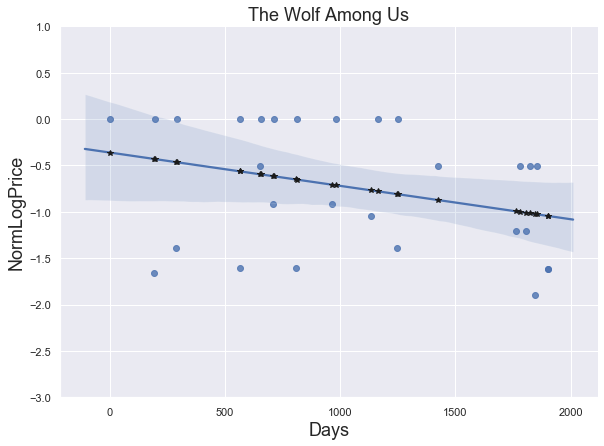

In [251]:
(a,b) = logprice_regplot(ps4_game_pricehist_dict['The Wolf Among Us'],'The Wolf Among Us',reg_model = True)

In [67]:
game = 'GTA V'

game = 'Borderlands: The Handsome Collection'

game = 'DmC: Devil May Cry Definitive Edition'

game = 'FIFA 16'

game = 'Saints Row IV: Re-Elected'

game = "Dying Light"

In [167]:
#ps4_game_list = pd.read_csv('ps4_game_list.csv')       
ps4_game_list.head()

ps4_game_pricehist_dict = get_all_price_hists(ps4_game_list)

pickle.dump(ps4_game_pricehist_dict, open('pricehist_pkl.sav', 'wb'))

Price history for game: #killallzombies was found: True
Price history for game: 10 Second Ninja X was found: True
Price history for game: 100ft Robot Golf was found: True
Price history for game: 101 Ways to Die was found: True
Price history for game: 11-11: Memories Retold was found: True
Price history for game: 13 Sentinels: Aegis Rim was found: False
Price history for game: 140 was found: True
Price history for game: 198X was found: True
Price history for game: 1001 Spikes was found: True
Price history for game: 2064: Read Only Memories was found: True
Price history for game: 20XX was found: False
Price history for game: The 25th Ward: The Silver Case was found: True
Price history for game: 2Dark was found: True
Price history for game: 428: Shibuya Scramble was found: True
Price history for game: 7 Days to Die was found: True
Price history for game: 8-bit Adventure Anthology: Volume I was found: True
Price history for game: 8-Bit Armies was found: True
Price history for game: 8-Bit H

Price history for game: Asterix & Obelix XXL 2: Mission: Las Vegum was found: False
Price history for game: Asterix & Obelix XXL 3: The Crystal Menhir was found: False
Price history for game: Astroneer was found: True
Price history for game: Atari Flashback Classics: Volume 1 was found: False
Price history for game: Atari Flashback Classics: Volume 2 was found: False
Price history for game: Atari Flashback Classics: Volume 3 was found: False
Price history for game: Atelier Ayesha: The Alchemist of Dusk DX was found: False
Price history for game: Atelier Escha & Logy: Alchemists of the Dusk Sky DX was found: True
Price history for game: Atelier Firis: The Alchemist and the Mysterious Journey was found: True
Price history for game: Atelier Lulua: The Scion of Arland was found: False
Price history for game: Atelier Lydie & Suelle: Alchemists of the Mysterious Painting was found: False
Price history for game: Atelier Meruru: The Apprentice of Arland was found: True
Price history for game: 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Price history for game: Beyond: Two Souls was found: True
Price history for game: Big Bash Boom was found: True
Price history for game: Big Pharma was found: True
Price history for game: Binaries was found: True
Price history for game: The Binding of Isaac: Rebirth was found: True
Price history for game: Biomutant was found: False
Price history for game: BioShock: The Collection was found: True
Price history for game: Birthdays the Beginning was found: True
Price history for game: Bit.Trip was found: True
Price history for game: Black & White Bushido was found: True
Price history for game: Black Desert Online was found: False
Price history for game: Blackguards 2 was found: True
Price history for game: Blackhole: Complete Edition was found: True
Price history for game: The Blackout Club was found: True
Price history for game: Black Paradox was found: True
Price history for game: Blacksad: Under the Skin was found: True
Price history for game: Blacksea Odyssey was found: True
Price hist

Price history for game: Chronicles of Teddy: Harmony of Exidus was found: True
Price history for game: The Church in the Darkness was found: True
Price history for game: Circuit Superstars was found: False
Price history for game: Cities: Skylines was found: False
Price history for game: Citizens of Earth was found: True
Price history for game: Citizens of Space was found: True
Price history for game: City Shrouded in Shadow was found: False
Price history for game: Civilization VI was found: True
Price history for game: Cladun Returns: This is Sengoku! was found: True
Price history for game: Claire: Extended Cut was found: True
Price history for game: Clannad was found: True
Price history for game: Claybook was found: True
Price history for game: Clockwork Tales: Of Glass and Ink was found: True
Price history for game: Close to the Sun was found: True
Price history for game: Clustertruck was found: True
Price history for game: Code Vein was found: True
Price history for game: Coffin Dod

Price history for game: Desperados III was found: False
Price history for game: Destiny was found: False
Price history for game: Destiny 2 was found: True
Price history for game: Destiny Connect: Tick-Tock Travelers was found: True
Price history for game: Destroy All Humans! Remake was found: False
Price history for game: Detroit: Become Human was found: True
Price history for game: Deus Ex: Mankind Divided was found: True
Price history for game: Devil Engine was found: False
Price history for game: Devil May Cry HD Collection was found: True
Price history for game: Devil May Cry 4: Special Edition was found: True
Price history for game: Devil May Cry 5 was found: False
Price history for game: Devious Dungeon was found: True
Price history for game: Devious Dungeon 2 was found: True
Price history for game: Dex was found: True
Price history for game: Diablo III was found: False
Price history for game: Diablo IV was found: False
Price history for game: Die for Valhalla! was found: False
P

Price history for game: Enigmatis: The Ghosts of Maple Creek was found: True
Price history for game: Enigmatis 2: The Mists of Ravenwood was found: True
Price history for game: Enigmatis 3: The Shadow of Karkhala was found: True
Price history for game: Enter the Gungeon was found: True
Price history for game: Entwined was found: True
Price history for game: Erica was found: True
Price history for game: Escape Plan was found: False
Price history for game: Escape Goat 2 was found: True
Price history for game: The Escapists was found: True
Price history for game: The Escapists 2 was found: True
Price history for game: ESP Ra.De. Psy was found: False
Price history for game: Ether One was found: True
Price history for game: Etherborn was found: True
Price history for game: Euro Fishing was found: True
Price history for game: Eve: Valkyrie - Warzone was found: True
Price history for game: Eventide: Slavic Fable was found: True
Price history for game: Eventide 2: Sorcerer's Mirror was found: 

Price history for game: Gal*Gun 2 was found: True
Price history for game: Gal Gunvolt was found: True
Price history for game: Game Dev Story was found: False
Price history for game: Game of Thrones was found: False
Price history for game: Gang Beasts was found: True
Price history for game: The Gardens Between was found: True
Price history for game: Garfield Kart: Furious Racing was found: True
Price history for game: Garou: Mark of the Wolves was found: False
Price history for game: Gas Guzzlers Extreme was found: True
Price history for game: Gauntlet: Slayer Edition was found: True
Price history for game: Gemini: Heroes Reborn was found: True
Price history for game: Gem Smashers was found: True
Price history for game: Generation Zero was found: True
Price history for game: Genshin Impact was found: False
Price history for game: Gensō No Rondo was found: False
Price history for game: Geometry Wars 3: Dimensions was found: True
Price history for game: Get Even was found: True
Price hist

Price history for game: Humanity was found: False
Price history for game: Hunt: Showdown was found: False
Price history for game: The Huntsman: Winter's Curse was found: True
Price history for game: Hyper Jam was found: True
Price history for game: Hyper Light Drifter was found: True
Price history for game: Hyper Void was found: True
Price history for game: I Am Bread was found: True
Price history for game: I Am Setsuna was found: True
Price history for game: Ice Age: Scrat’s Nutty Adventure was found: True
Price history for game: Icewind Dale: Enhanced Edition was found: True
Price history for game: Icey was found: True
Price history for game: Iconoclasts was found: True
Price history for game: The Idolmaster Platinum Stars was found: False
Price history for game: The Idolmaster: Stella Stage was found: False
Price history for game: Ikaruga was found: True
Price history for game: Illusion of L'Phalcia was found: True
Price history for game: Impact Winter was found: True
Price history 

Price history for game: Kotodama: The 7 Mysteries of Fujisawa was found: True
Price history for game: Kromaia Omega was found: False
Price history for game: Kunio-kun: The World Classics Collection was found: False
Price history for game: Kwaidan: Azuma Manor Story was found: False
Price history for game: Labyrinth Life was found: True
Price history for game: Labyrinth of Galleria: Coven of Dusk was found: False
Price history for game: Labyrinth of Refrain: Coven of Dusk was found: True
Price history for game: LA Cops was found: True
Price history for game: L.A. Noire was found: True
Price history for game: La-Mulana was found: False
Price history for game: La-Mulana 2 was found: False
Price history for game: Langrisser I & II HD Remastered was found: False
Price history for game: Lapis x Labyrinth was found: True
Price history for game: Lara Croft and the Temple of Osiris was found: False
Price history for game: Lara Croft Go was found: True
Price history for game: Laser League was fo

Price history for game: Marvel: Ultimate Alliance 2 was found: False
Price history for game: Marvel vs. Capcom: Infinite was found: False
Price history for game: Mary Skelter 2 was found: False
Price history for game: Masquerada: Songs and Shadows was found: True
Price history for game: Mass Effect: Andromeda was found: False
Price history for game: Matterfall was found: True
Price history for game: Max: The Curse of Brotherhood was found: True
Price history for game: McDroid was found: True
Price history for game: MediEvil was found: False
Price history for game: Mega Coin Squad was found: True
Price history for game: Mega Man 11 was found: True
Price history for game: Mega Man Legacy Collection was found: False
Price history for game: Mega Man Legacy Collection 2 was found: True
Price history for game: Mega Man X Legacy Collection was found: True
Price history for game: Mega Man X Legacy Collection 2 was found: True
Price history for game: Mega Man Zero/ZX Legacy Collection was found

Price history for game: NBA 2K16 was found: False
Price history for game: NBA 2K17 was found: False
Price history for game: NBA 2K18 was found: True
Price history for game: NBA 2K19 was found: True
Price history for game: NBA 2K20 was found: True
Price history for game: NBA Live 14 was found: False
Price history for game: NBA Live 15 was found: False
Price history for game: NBA Live 16 was found: True
Price history for game: NBA Live 18 was found: True
Price history for game: NBA Live 19 was found: False
Price history for game: NBA Playgrounds was found: False
Price history for game: Necrobarista was found: True
Price history for game: Necropolis was found: True
Price history for game: Need for Speed was found: False
Price history for game: Need for Speed: Heat was found: False
Price history for game: Need for Speed: Payback was found: False
Price history for game: Need for Speed: Rivals was found: False
Price history for game: Nelke & the Legendary Alchemists: Ateliers of the New Worl

Price history for game: Peggle 2 was found: True
Price history for game: Penarium was found: True
Price history for game: Penguin Wars was found: True
Price history for game: Perception was found: True
Price history for game: Perfect Universe was found: True
Price history for game: Persian Nights: Sands of Wonders was found: True
Price history for game: The Persistence was found: True
Price history for game: Persona 3: Dancing Moon Night was found: False
Price history for game: Persona 4: Dancing All Night was found: False
Price history for game: Persona 5 was found: True
Price history for game: Persona 5: Dancing Star Night was found: False
Price history for game: Persona 5 Royal was found: True
Price history for game: Persona 5 Scramble was found: False
Price history for game: Phantom Blade: Mirage was found: False
Price history for game: Phantom Breaker: Battle Grounds Overdrive was found: False
Price history for game: Phantom Doctrine was found: True
Price history for game: Phantom

Price history for game: R.B.I. Baseball 18 was found: True
Price history for game: R.B.I. Baseball 19 was found: True
Price history for game: R.B.I. Baseball 20 was found: False
Price history for game: ReadySet Heroes was found: True
Price history for game: Real Farm was found: True
Price history for game: Realms of Arkania was found: False
Price history for game: Rebel Cops was found: True
Price history for game: Rebel Galaxy was found: True
Price history for game: Red Dead Redemption 2 was found: True
Price history for game: Red Faction: Guerilla was found: True
Price history for game: Redout was found: True
Price history for game: Redeemer: Enhanced Edition was found: True
Price history for game: Reel Fishing: Road Trip Adventure was found: True
Price history for game: Refactor was found: False
Price history for game: Refight: The Last Warship was found: False
Price history for game: Refunct was found: True
Price history for game: Regalia: Of Men and Monarchs was found: False
Price 

Price history for game: Senran Kagura 7EVEN was found: False
Price history for game: Senri no Kifu: Gendai Shougi Mystery was found: False
Price history for game: Sephirothic Stories was found: True
Price history for game: Seraph was found: True
Price history for game: Seraphim was found: False
Price history for game: Serial Cleaner was found: True
Price history for game: Seum: Speedrunners from Hell was found: True
Price history for game: The Seven Deadly Sins: Knights of Britannia was found: True
Price history for game: The Sexy Brutale was found: True
Price history for game: Shadow Complex Remastered was found: True
Price history for game: Shadow Corridor was found: False
Price history for game: Shadowgate was found: True
Price history for game: Shadow of the Beast was found: True
Price history for game: Shadow of the Colossus was found: True
Price history for game: Shadow of the Tomb Raider was found: True
Price history for game: Shadows: Awakening was found: True
Price history for

Price history for game: Star Trek: Bridge Crew was found: True
Price history for game: Star Wars Battlefront was found: False
Price history for game: Star Wars Battlefront II was found: False
Price history for game: Star Wars Jedi: Fallen Order was found: True
Price history for game: Star Wars Jedi Knight II: Jedi Outcast was found: True
Price history for game: Star Wars Jedi Knight: Jedi Academy was found: False
Price history for game: Starwhal: Just the Tip was found: False
Price history for game: State of Mind was found: True
Price history for game: Stay was found: True
Price history for game: Stay Cool, Kobayashi-san!: A River City Ransom Story was found: True
Price history for game: Stealth Inc: A Clone in the Dark was found: False
Price history for game: Stealth Inc 2: A Game of Clones was found: True
Price history for game: SteamWorld Dig was found: False
Price history for game: SteamWorld Dig 2 was found: True
Price history for game: SteamWorld Heist was found: True
Price histo

Price history for game: Tetraminos was found: True
Price history for game: Tetris Effect was found: True
Price history for game: Tetris Ultimate was found: False
Price history for game: Tharsis was found: True
Price history for game: That's You! was found: True
Price history for game: The Last Remnant Remastered was found: True
Price history for game: Thea: The Awakening was found: True
Price history for game: There Came an Echo was found: False
Price history for game: They Are Billions was found: True
Price history for game: Thief was found: True
Price history for game: Thief Town was found: True
Price history for game: Thimbleweed Park was found: True
Price history for game: This Is Pool was found: False
Price history for game: This Is Snooker was found: False
Price history for game: This Is the Police was found: False
Price history for game: This War of Mine: The Little Ones was found: True
Price history for game: Thomas Was Alone was found: True
Price history for game: Thumper was 

Price history for game: Utawarerumono: Prelude to the Fallen was found: False
Price history for game: Utawarerumono: Zan was found: True
Price history for game: VA-11 Hall-A: Cyberpunk Bartender Action was found: True
Price history for game: Valentino Rossi: The Game was found: False
Price history for game: Valfaris was found: True
Price history for game: Valhalla Hills: Definitive Edition was found: True
Price history for game: Valiant Hearts: The Great War was found: True
Price history for game: Valkyria Chronicles 4 was found: True
Price history for game: Valkyria Chronicles Remastered was found: True
Price history for game: Valkyria Revolution was found: True
Price history for game: Valley was found: True
Price history for game: Vanquish was found: True
Price history for game: Vambrace: Cold Soul was found: True
Price history for game: Vampire: The Masquerade – Bloodlines 2 was found: False
Price history for game: Vampyr was found: True
Price history for game: Vane was found: True


Price history for game: Yakuza Ishin was found: False
Price history for game: Yakuza: Kiwami was found: False
Price history for game: Yakuza Kiwami 2 was found: True
Price history for game: Yakuza: Like a Dragon was found: False
Price history for game: The Yakuza Remastered Collection was found: True
Price history for game: Yesterday Origins was found: True
Price history for game: Yo-kai Watch 4++ was found: False
Price history for game: Yoku's Island Express was found: True
Price history for game: Yomawari: Midnight Shadows was found: True
Price history for game: Yonder: The Cloud Catcher Chronicles was found: True
Price history for game: Yooka-Laylee was found: True
Price history for game: Yooka-Laylee and the Impossible Lair was found: True
Price history for game: Ys: Memories of Celceta was found: False
Price history for game: Ys Origin was found: True
Price history for game: Ys VIII: Lacrimosa of Dana was found: True
Price history for game: Ys IX: Monstrum Nox was found: False
Pri

In [185]:
faileddf = ps4_game_list[~ps4_game_list['HistScrapped']]
faileddf['Links'] = faileddf['TitlesHTML'].apply(lambda x: 'https://psprices.com/region-us/search/?q={}&platform=PS4&dlc=hide'.format(x))


In [196]:
game = 1
print(faileddf[['Titles','Links']].iloc[game,0])
print(faileddf[['Titles','Links']].iloc[game,1])


20XX
https://psprices.com/region-us/search/?q=20xx&platform=PS4&dlc=hide
